# MobileNet V1 模型总结

## 关键创新点

### 1. 深度可分离卷积（Depthwise Separable Convolution）
- 将标准卷积分解为两个独立操作：
  - **Depthwise Convolution（逐通道卷积）**：对每个输入通道单独进行卷积操作。
  - **Pointwise Convolution（逐点卷积）**：使用 `1x1` 卷积融合不同通道的信息。
- 大幅减少了计算量和参数数量，适用于移动端和嵌入式设备。这一点和新出的MLP-Mixer的结构及其接近.

### 2. 轻量化设计
- 在保证准确率的前提下，通过减少冗余计算实现高效推理。
- 相比传统卷积网络（如VGG、Inception等），模型大小显著减小。

### 3. 宽度乘子（Width Multiplier）
- 引入超参数 `α ∈ (0,1]` 控制输入输出通道数，进一步压缩模型。
- 可以在精度与速度之间做权衡，提升部署灵活性。

### 4. 分辨率乘子（Resolution Multiplier）
- 控制输入图像的分辨率，作为另一个控制模型复杂度的参数。
- 允许根据设备性能调整输入尺寸，从而影响整体计算量。

### 5. 模块化结构
- 整体网络由多个堆叠的深度可分离卷积模块构成，便于复用和扩展。

---

## 缺点与局限性

### 1. 精度略低于标准模型
- 在相同数据集下，相比 ResNet、Inception 等大型模型，在 Top-1 准确率上略有下降。

### 2. 感受野受限
- 使用较多的小卷积核（如 3x3）和深度卷积，可能限制了特征提取的感受野范围。

### 3. 依赖手动设计
- 网络结构是人工设计的，没有像后续版本（如 MobileNetV2、NASNet）那样利用神经网络架构搜索（NAS）来优化性能。

### 4. 信息流动效率较低
- 深度可分离卷积可能导致特征表达能力受限，特别是在高层语义任务中表现不如密集连接的网络。

---

## 总结

MobileNet V1 是一个开创性的轻量级卷积神经网络，其核心思想 —— **深度可分离卷积**，为后续轻量化模型的发展奠定了基础。尽管它在精度和表达能力上有所妥协，但在移动设备和边缘计算场景中具有重要的应用价值。

In [1]:
# 自动重新加载外部module，使得修改代码之后无需重新import
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

from hdd.device.utils import get_device

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

# 设置训练数据的路径
DATA_ROOT = "~/workspace/hands-dirty-on-dl/dataset"
# 设置TensorBoard的路径
TENSORBOARD_ROOT = "~/workspace/hands-dirty-on-dl/dataset"
# 设置预训练模型参数路径
TORCH_HUB_PATH = "~/workspace/hands-dirty-on-dl/pretrained_models"
torch.hub.set_dir(TORCH_HUB_PATH)
# 挑选最合适的训练设备
DEVICE = get_device(["cuda", "cpu"])
print("Use device: ", DEVICE)

Use device:  cuda


In [2]:
from hdd.dataset.imagenette_in_memory import ImagenetteInMemory
from hdd.data_util.transforms import RandomResize
from torch.utils.data import DataLoader

TRAIN_MEAN = [0.4625, 0.4580, 0.4295]
TRAIN_STD = [0.2452, 0.2390, 0.2469]
train_dataset_transforms = transforms.Compose(
    [
        RandomResize([256, 296, 384]),  # 随机在三个size中选择一个进行resize
        transforms.RandomRotation(10),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=TRAIN_MEAN, std=TRAIN_STD),
    ]
)
val_dataset_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=TRAIN_MEAN, std=TRAIN_STD),
    ]
)
train_dataset = ImagenetteInMemory(
    root=DATA_ROOT,
    split="train",
    size="full",
    download=True,
    transform=train_dataset_transforms,
)
val_dataset = ImagenetteInMemory(
    root=DATA_ROOT,
    split="val",
    size="full",
    download=True,
    transform=val_dataset_transforms,
)


def build_dataloader(batch_size, train_dataset, val_dataset):
    train_dataloader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=8
    )
    val_dataloader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, num_workers=8
    )
    return train_dataloader, val_dataloader

In [3]:
from hdd.models.cnn.mobilenet_v1 import MobileNetV1
from hdd.train.classification_utils import (
    naive_train_classification_model,
    eval_image_classifier,
)
from hdd.models.nn_utils import count_trainable_parameter


def train_net(
    train_dataloader,
    val_dataloader,
    width_multiplier,
    lr=1e-3,
    weight_decay=1e-5,
    max_epochs=100,
) -> tuple[MobileNetV1, dict[str, list[float]]]:
    net = MobileNetV1(num_classes=10, width_multiplier=width_multiplier).to(DEVICE)
    print(f"#Parameter: {count_trainable_parameter(net)}")
    criteria = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = torch.optim.AdamW(net.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, max_epochs, eta_min=lr / 100
    )
    training_stats = naive_train_classification_model(
        net,
        criteria,
        max_epochs,
        train_dataloader,
        val_dataloader,
        DEVICE,
        optimizer,
        scheduler,
        verbose=True,
    )
    return net, training_stats


train_dataloader, val_dataloader = build_dataloader(64, train_dataset, val_dataset)

net, width_multiplier_1 = train_net(
    train_dataloader,
    val_dataloader,
    width_multiplier=1,
    lr=0.001,
    weight_decay=0,
)

eval_result = eval_image_classifier(net, val_dataloader.dataset, DEVICE)
ss = [result.gt_label == result.predicted_label for result in eval_result]
print(f"#Parameter: {count_trainable_parameter(net)} Accuracy: {sum(ss) / len(ss)}")

#Parameter: 3228170
Epoch: 1/100 Train Loss: 1.9463 Accuracy: 0.3403 Time: 10.84477  | Val Loss: 1.7106 Accuracy: 0.4645
Epoch: 2/100 Train Loss: 1.6502 Accuracy: 0.5048 Time: 11.20975  | Val Loss: 1.5851 Accuracy: 0.5361
Epoch: 3/100 Train Loss: 1.5138 Accuracy: 0.5675 Time: 12.50287  | Val Loss: 1.5415 Accuracy: 0.5725
Epoch: 4/100 Train Loss: 1.3966 Accuracy: 0.6190 Time: 11.35471  | Val Loss: 1.3085 Accuracy: 0.6459
Epoch: 5/100 Train Loss: 1.3249 Accuracy: 0.6478 Time: 10.26332  | Val Loss: 1.2718 Accuracy: 0.6859
Epoch: 6/100 Train Loss: 1.2855 Accuracy: 0.6732 Time: 10.22753  | Val Loss: 1.2369 Accuracy: 0.7080
Epoch: 7/100 Train Loss: 1.2476 Accuracy: 0.6963 Time: 11.17076  | Val Loss: 1.2019 Accuracy: 0.7111
Epoch: 8/100 Train Loss: 1.1980 Accuracy: 0.7114 Time: 12.06234  | Val Loss: 1.1339 Accuracy: 0.7447
Epoch: 9/100 Train Loss: 1.1789 Accuracy: 0.7207 Time: 11.74540  | Val Loss: 1.0687 Accuracy: 0.7715
Epoch: 10/100 Train Loss: 1.1362 Accuracy: 0.7431 Time: 10.94621  | Val

In [4]:
net, width_multiplier_75 = train_net(
    train_dataloader,
    val_dataloader,
    width_multiplier=0.75,
    lr=0.001,
    weight_decay=0,
)

eval_result = eval_image_classifier(net, val_dataloader.dataset, DEVICE)
ss = [result.gt_label == result.predicted_label for result in eval_result]
print(f"#Parameter: {count_trainable_parameter(net)} Accuracy: {sum(ss) / len(ss)}")

#Parameter: 1832458
Epoch: 1/100 Train Loss: 1.9838 Accuracy: 0.3209 Time: 8.84561  | Val Loss: 1.7374 Accuracy: 0.4555
Epoch: 2/100 Train Loss: 1.7226 Accuracy: 0.4672 Time: 9.60424  | Val Loss: 1.7083 Accuracy: 0.4958
Epoch: 3/100 Train Loss: 1.5929 Accuracy: 0.5289 Time: 8.51767  | Val Loss: 1.5186 Accuracy: 0.5656
Epoch: 4/100 Train Loss: 1.4970 Accuracy: 0.5756 Time: 8.69518  | Val Loss: 1.4907 Accuracy: 0.5985
Epoch: 5/100 Train Loss: 1.4205 Accuracy: 0.6132 Time: 9.62786  | Val Loss: 1.3374 Accuracy: 0.6525
Epoch: 6/100 Train Loss: 1.3724 Accuracy: 0.6317 Time: 9.07552  | Val Loss: 1.2628 Accuracy: 0.6800
Epoch: 7/100 Train Loss: 1.3105 Accuracy: 0.6610 Time: 7.98369  | Val Loss: 1.1988 Accuracy: 0.7096
Epoch: 8/100 Train Loss: 1.2688 Accuracy: 0.6786 Time: 9.35858  | Val Loss: 1.2670 Accuracy: 0.6780
Epoch: 9/100 Train Loss: 1.2183 Accuracy: 0.7002 Time: 9.14687  | Val Loss: 1.1775 Accuracy: 0.7152
Epoch: 10/100 Train Loss: 1.2083 Accuracy: 0.7075 Time: 7.90328  | Val Loss: 1.1

In [5]:
net, width_multiplier_50 = train_net(
    train_dataloader,
    val_dataloader,
    width_multiplier=0.5,
    lr=0.001,
    weight_decay=0,
)

eval_result = eval_image_classifier(net, val_dataloader.dataset, DEVICE)
ss = [result.gt_label == result.predicted_label for result in eval_result]
print(f"#Parameter: {count_trainable_parameter(net)} Accuracy: {sum(ss) / len(ss)}")

#Parameter: 829194
Epoch: 1/100 Train Loss: 1.9936 Accuracy: 0.3139 Time: 6.86565  | Val Loss: 2.3369 Accuracy: 0.2978
Epoch: 2/100 Train Loss: 1.7558 Accuracy: 0.4430 Time: 7.59550  | Val Loss: 1.6754 Accuracy: 0.5078
Epoch: 3/100 Train Loss: 1.6337 Accuracy: 0.5026 Time: 7.09340  | Val Loss: 1.5563 Accuracy: 0.5424
Epoch: 4/100 Train Loss: 1.5453 Accuracy: 0.5504 Time: 6.89551  | Val Loss: 1.5335 Accuracy: 0.5648
Epoch: 5/100 Train Loss: 1.4806 Accuracy: 0.5782 Time: 7.34388  | Val Loss: 1.3876 Accuracy: 0.6280
Epoch: 6/100 Train Loss: 1.4097 Accuracy: 0.6202 Time: 7.13816  | Val Loss: 1.3523 Accuracy: 0.6423
Epoch: 7/100 Train Loss: 1.3729 Accuracy: 0.6254 Time: 6.96955  | Val Loss: 1.2841 Accuracy: 0.6869
Epoch: 8/100 Train Loss: 1.3036 Accuracy: 0.6643 Time: 7.31129  | Val Loss: 1.2063 Accuracy: 0.7060
Epoch: 9/100 Train Loss: 1.2708 Accuracy: 0.6741 Time: 7.12056  | Val Loss: 1.1858 Accuracy: 0.7182
Epoch: 10/100 Train Loss: 1.2347 Accuracy: 0.6943 Time: 6.54942  | Val Loss: 1.14

In [6]:
net, width_multiplier_25 = train_net(
    train_dataloader,
    val_dataloader,
    width_multiplier=0.25,
    lr=0.001,
    weight_decay=0,
)

eval_result = eval_image_classifier(net, val_dataloader.dataset, DEVICE)
ss = [result.gt_label == result.predicted_label for result in eval_result]
print(f"#Parameter: {count_trainable_parameter(net)} Accuracy: {sum(ss) / len(ss)}")

#Parameter: 218378
Epoch: 1/100 Train Loss: 2.0854 Accuracy: 0.2563 Time: 5.72556  | Val Loss: 2.0358 Accuracy: 0.2846
Epoch: 2/100 Train Loss: 1.9061 Accuracy: 0.3611 Time: 5.97036  | Val Loss: 1.9750 Accuracy: 0.3559
Epoch: 3/100 Train Loss: 1.7826 Accuracy: 0.4299 Time: 6.48467  | Val Loss: 1.7037 Accuracy: 0.4698
Epoch: 4/100 Train Loss: 1.6980 Accuracy: 0.4725 Time: 6.27422  | Val Loss: 1.5573 Accuracy: 0.5376
Epoch: 5/100 Train Loss: 1.6299 Accuracy: 0.5067 Time: 5.80984  | Val Loss: 1.5043 Accuracy: 0.5656
Epoch: 6/100 Train Loss: 1.5854 Accuracy: 0.5303 Time: 6.53588  | Val Loss: 1.4381 Accuracy: 0.5954
Epoch: 7/100 Train Loss: 1.5458 Accuracy: 0.5488 Time: 6.44825  | Val Loss: 1.5098 Accuracy: 0.5687
Epoch: 8/100 Train Loss: 1.5002 Accuracy: 0.5705 Time: 5.77631  | Val Loss: 1.3840 Accuracy: 0.6204
Epoch: 9/100 Train Loss: 1.4775 Accuracy: 0.5819 Time: 6.34738  | Val Loss: 1.3446 Accuracy: 0.6464
Epoch: 10/100 Train Loss: 1.4491 Accuracy: 0.6007 Time: 6.65502  | Val Loss: 1.32

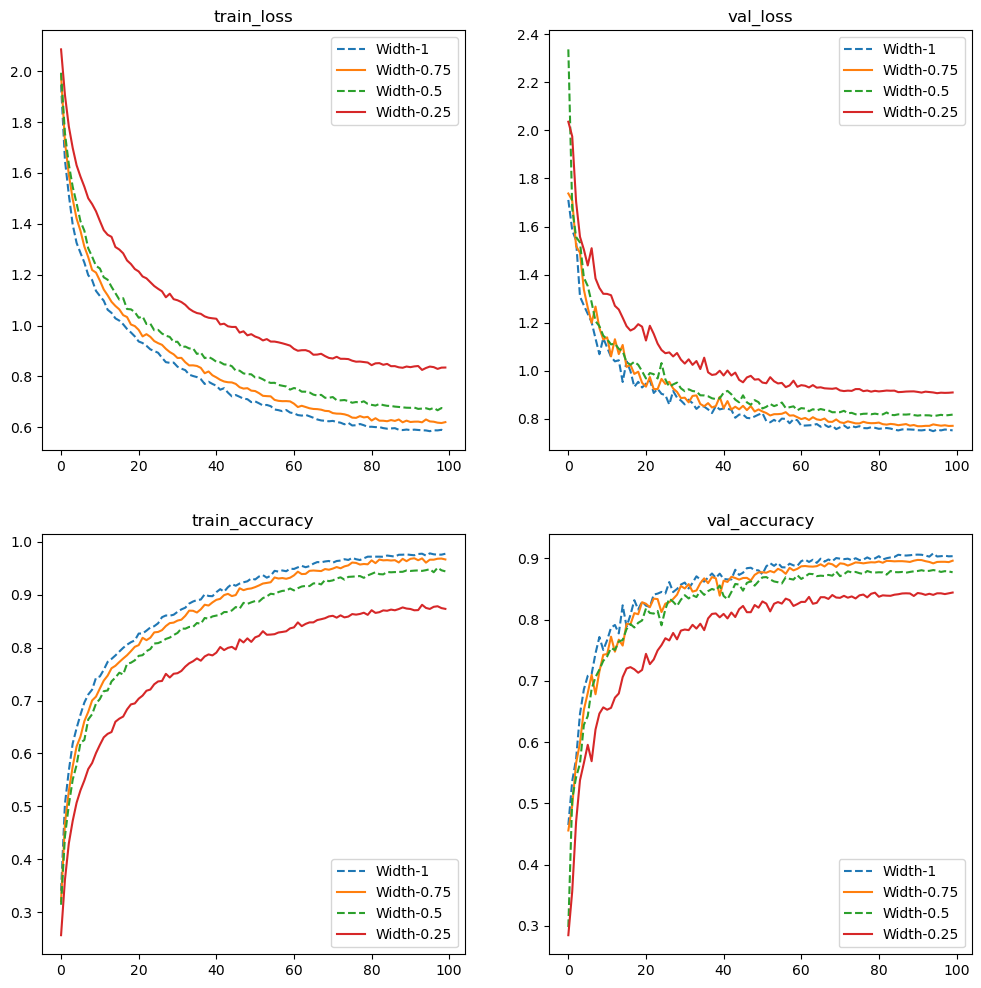

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))
fields = width_multiplier_1.keys()
for i, field in enumerate(fields):
    plt.subplot(2, 2, i+1)
    plt.plot(width_multiplier_1[field], label="Width-1", linestyle="--")
    plt.plot(width_multiplier_75[field], label="Width-0.75")
    plt.plot(width_multiplier_50[field], label="Width-0.5", linestyle="--")
    plt.plot(width_multiplier_25[field], label="Width-0.25", linestyle="-")
    plt.legend()
    plt.title(field)